# Logistic Regression

### Testing out the results of logistic regression on just stock market data

The idea is to transform the stock market data into a series of binary classification tasks. I will be testing a few different tagets:

- single day prediction
- single week
- test a differenced data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# import the data
filepath='../../data/SPY_1993-01-29_2022-08-17.csv'
data = pd.read_csv(filepath)

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.438103,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.619028,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.673309,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.944679,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.053232,531500


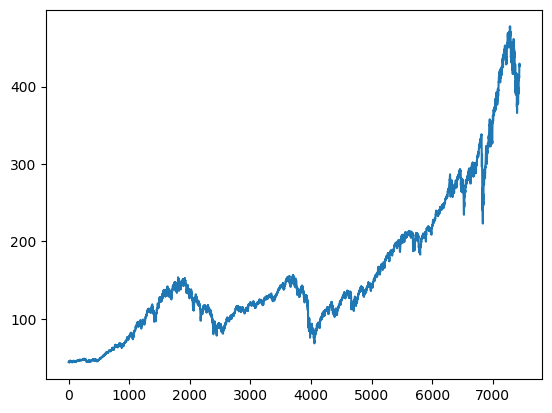

In [3]:
sns.lineplot(data=data['Close'].values);

In [4]:
# Creating single day labels
diff_df = data['Close'].diff()
diff_df.index = pd.to_datetime(data['Date'])
diff_df.head()

Date
1993-01-29        NaN
1993-02-01    0.31250
1993-02-02    0.09375
1993-02-03    0.46875
1993-02-04    0.18750
Name: Close, dtype: float64

In [5]:
labels = diff_df > 0
labels.tail()

Date
2022-08-11    False
2022-08-12     True
2022-08-15     True
2022-08-16     True
2022-08-17    False
Name: Close, dtype: bool

In [6]:
# shift the labels to fit the correct index
labels = labels.shift(periods=-1)

# drop the remaining NaN
labels = labels.dropna().astype(float)

In [7]:
labels.tail()

Date
2022-08-10    0.0
2022-08-11    1.0
2022-08-12    1.0
2022-08-15    1.0
2022-08-16    0.0
Name: Close, dtype: float64

In [8]:
# method to split the sequences into smaller portions for regression
def split_sequences(sequence, window_size):
    X = []
    for i in range(len(sequence)):
        end_ix = i + window_size
        if end_ix > len(sequence) - 1:
            break
        seq = sequence[i:end_ix]
        X.append(seq)
    return np.array(X)

In [9]:
from sklearn.model_selection import train_test_split

window_size = 5
X = split_sequences(data['Close'], window_size=window_size)
X = X[:-1]
y = labels[5:]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y.values, random_state=42)

In [10]:
print(len(X_train), len(y_train))

5577 5577


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



clf = LogisticRegression(random_state=42).fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

0.5228617536309844


In [12]:
# using regular numbers did not work, going to normalize the inputs
percents = data['Close'].pct_change(periods=1)
percents.head()

0         NaN
1    0.007112
2    0.002119
3    0.010571
4    0.004184
Name: Close, dtype: float64

In [13]:
window_size = 5
X = split_sequences(percents, window_size=window_size)
X = X[1:-1]
y = labels[6:]

X_train, X_test, y_train, y_test = train_test_split(X, y.values, random_state=42)

In [14]:
print(len(X), len(y))

7435 7435


In [15]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

0.5309306078536847


Still not great, doing some model tuning

In [16]:
from sklearn.model_selection import RandomizedSearchCV

params = {'C':[.001, .01, .1, 1, 10, 100]}

clf = LogisticRegression()
selector = RandomizedSearchCV(estimator=clf, param_distributions=params)

result = selector.fit(X_train, y_train)
print('Best: %f using %s' % (result.best_score_, result.best_params_))
best_model = result.best_estimator_
print(accuracy_score(best_model.predict(X_test), y_test))

C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best: 0.535868 using {'C': 0.001}
0.5309306078536847


### Trying out logistic regression for a week in advance

In [17]:
five_df = data[['Date', 'Close']]
five_df['Date'] = pd.to_datetime(five_df['Date'])
five_df = five_df.set_index('Date')
five_df = five_df.diff(-5) * -1
five_df.dropna(inplace=True)
five_df.head(10)

C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close
Date,
1993-01-29,1.03125
1993-02-01,0.71875
1993-02-02,0.31250
1993-02-03,-0.09375
1993-02-04,-0.06250
1993-02-05,-0.37500
1993-02-08,-1.50000
1993-02-09,-1.21875
1993-02-10,-1.31250


In [18]:
labels = five_df > 0
labels = labels.astype(float)
labels

,Close
Date,
1993-01-29,1.0
1993-02-01,1.0
1993-02-02,1.0
1993-02-03,0.0
1993-02-04,0.0
...,...
2022-08-04,1.0
2022-08-05,1.0
2022-08-08,1.0


In [19]:
type(labels)

pandas.core.frame.DataFrame

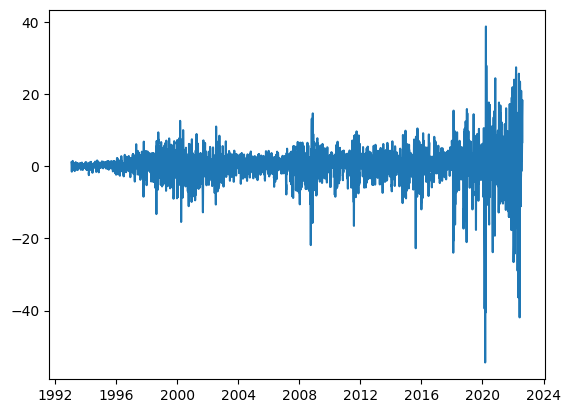

In [20]:
plt.plot(five_df)

In [21]:
from sklearn.model_selection import train_test_split

window_size = 5
X = split_sequences(data['Close'], window_size=window_size)
X = X
y = labels

# split the data
X_train, X_test, y_train, y_test = train_test_split(X[5:], y.values[:-5], shuffle=False)

In [22]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
print(accuracy_score(y_test.reshape(-1,), clf.predict(X_test).reshape(-1,)))

0.6318622174381054


C:\Users\jr101\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
# null accuracy
pd.DataFrame(y_test).value_counts()

1.0    1132
0.0     726
dtype: int64

In [24]:
# null accuracy (guessing most frequent)
max(y_test.mean(), 1 - y_test.mean())

0.6092572658772875

In [25]:
pd.concat([pd.Series(clf.predict(X_test)), pd.Series(y_test.ravel())], axis=1).tail()

,0,1
1853,1.0,1.0
1854,1.0,1.0
1855,0.0,1.0
1856,0.0,1.0
1857,0.0,1.0


In [26]:
from sklearn.metrics import precision_score, recall_score

print('precision = %f, recall = %f' %(precision_score(y_test.ravel(), clf.predict(X_test)), recall_score(y_test.ravel(), clf.predict(X_test))))

precision = 0.633652, recall = 0.938163


In [27]:
y_pred = clf.predict(X_test)

In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.ravel(), y_pred.ravel()))

[[ 112  614]
 [  70 1062]]


I don't believe that logistic regression can do this well on the data, I will try on the apple stock now as a sanity check

In [29]:
apple_df = pd.read_csv('../../data/AAPL_1980-12-12_2022-08-17.csv')
apple_df.head(8)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098300,48630400
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.103084,37363200
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.107434,46950400


In [30]:
# read in apple data
my_df = apple_df.rename(str.lower, axis=1)
my_df.date = pd.to_datetime(my_df.date)
my_df = my_df.set_index('date')
my_df = my_df.rename(mapper={'adj close': 'adj_close'}, axis=1)

In [31]:
data = my_df.adj_close
X = split_sequences(data, 5)

In [32]:
X

array([[1.00039482e-01, 9.48203877e-02, 8.78607705e-02, 9.00354013e-02,
        9.26457420e-02],
       [9.48203877e-02, 8.78607705e-02, 9.00354013e-02, 9.26457420e-02,
        9.82997492e-02],
       [8.78607705e-02, 9.00354013e-02, 9.26457420e-02, 9.82997492e-02,
        1.03084005e-01],
       ...,
       [1.64869995e+02, 1.64919998e+02, 1.69240005e+02, 1.68490005e+02,
        1.72100006e+02],
       [1.64919998e+02, 1.69240005e+02, 1.68490005e+02, 1.72100006e+02,
        1.73190002e+02],
       [1.69240005e+02, 1.68490005e+02, 1.72100006e+02, 1.73190002e+02,
        1.73029999e+02]])

In [33]:
labels = my_df.adj_close.diff(-5) * -1
labels = labels.dropna()
labels = labels > 0
labels = labels.astype(float)
labels

date
1980-12-12    0.0
1980-12-15    1.0
1980-12-16    1.0
1980-12-17    1.0
1980-12-18    1.0
             ... 
2022-08-04    1.0
2022-08-05    1.0
2022-08-08    1.0
2022-08-09    1.0
2022-08-10    1.0
Name: adj_close, Length: 10504, dtype: float64

In [34]:
print(len(X[5:]),len(labels[:-5]))

10499 10499


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X[5:], labels.values[:-5], random_state=42)

In [36]:
clf = LogisticRegression(random_state=42).fit(X_train, y_train)

preds = clf.predict(X_test)
print('precision = %f, recall = %f' %(precision_score(y_test.ravel(), preds), recall_score(y_test.ravel(), preds)))

precision = 0.542476, recall = 1.000000


In [37]:
accuracy_score(y_test, preds)

0.5424761904761904